# BIT Detection Kit Prototyping Demo Notebook
The following notebook describes the steps taken and outputs obtained using Mask R-CNN for object detection.

## Setup
The following cells set up the libraries that are required for us to train and validate the model.

### Install Required Dependencies

In [ ]:
# import os
# # Root directory of the project
# ROOT_DIR = os.path.abspath("../")

# Install dependecies
!cd ../ && \
pip3 install -r requirements.txt && \
python3 setup.py install

### Import Packages

In [1]:
import os
# Root directory of the project
ROOT_DIR = os.path.abspath("../")
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log


from src import dkit
%matplotlib inline

Using TensorFlow backend.


### Configurations

Run one of the code blocks below to import and load the configurations to use.

In [2]:
config = dkit.DkitConfig()
DATA_DIR = os.path.join(ROOT_DIR, "datasets")

### Download & Extract Dataset
We download the dataset file and extract the dataset.

In [ ]:
!wget -P $DATA_DIR https://s3-ap-southeast-1.amazonaws.com/dkitdatasets/Archive.zip
!unzip -o $DATA_DIR/Archive.zip -d $DATA_DIR

### Loading the Dataset

In [3]:
# Load dataset
# Get the dataset from the releases page
# https://github.com/matterport/Mask_RCNN/releases
dataset = dkit.DkitDataset()
dataset.load_dkit(DATA_DIR+'/IKEA_FIXA', "train")

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 77
Class Count: 5
  0. BG                                                
  1. Drill                                             
  2. Screw                                             
  3. Charger                                           
  4. Bit 1                                             


### Display Samples

Load and display images and masks.

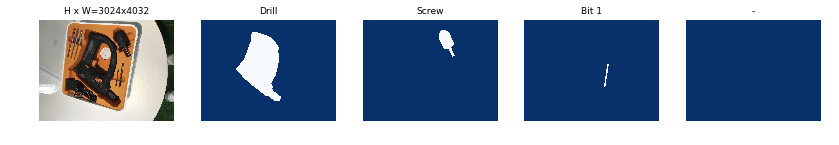

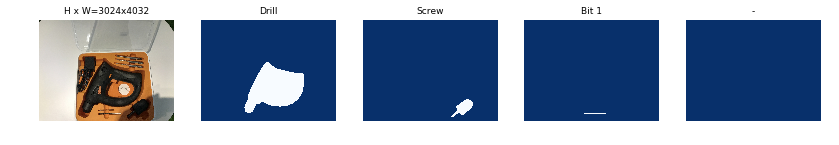

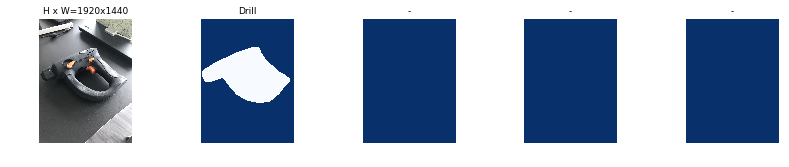

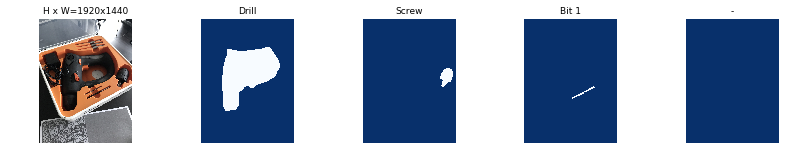

In [4]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

In [5]:
!python3 dkit.py train --dataset=../datasets/IKEA_FIXA --weights=coco

Using TensorFlow backend.
Weights:  coco
Dataset:  ../datasets/IKEA_FIXA
Logs:  /home/ubuntu/Dkit/logs

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0

Epoch 11/30
100/100 [==============================] - 281s 3s/step - loss: 0.1948 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0699 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.0281 - mrcnn_mask_loss: 0.0680 - val_loss: 0.8796 - val_rpn_class_loss: 0.0057 - val_rpn_bbox_loss: 0.3341 - val_mrcnn_class_loss: 0.0362 - val_mrcnn_bbox_loss: 0.2459 - val_mrcnn_mask_loss: 0.2577
Epoch 12/30
100/100 [==============================] - 282s 3s/step - loss: 0.2023 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.0728 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0268 - mrcnn_mask_loss: 0.0736 - val_loss: 0.8577 - val_rpn_class_loss: 0.0065 - val_rpn_bbox_loss: 0.3238 - val_mrcnn_class_loss: 0.0320 - val_mrcnn_bbox_loss: 0.2622 - val_mrcnn_mask_loss: 0.2332
Epoch 13/30
100/100 [==============================] - 279s 3s/step - loss: 0.2080 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0877 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.0274 - mrcnn_mask_loss: 0.0683 - val_loss: 0.8913 - val_rpn_clas